In [0]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss, MSELoss

##Check that GPU is available

In [0]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


# Import Hugging Face Transformers

In [0]:
!pip install transformers

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import AdamW, GPT2Model, GPT2Tokenizer, GPT2PreTrainedModel, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import pandas as pd
import io
import random
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

# Pull data from git repo (the repo has to be public to allow for accessing individual files)

In [0]:
!curl -o test.csv https://bitbucket.org/jtfitzpa/eecs595_project/raw/324252a5e6c5beabb1bdf174c38b0899dcf31438/data/test.csv
!curl -o train.csv https://bitbucket.org/jtfitzpa/eecs595_project/raw/324252a5e6c5beabb1bdf174c38b0899dcf31438/data/train.csv
!curl -o validate.csv https://bitbucket.org/jtfitzpa/eecs595_project/raw/324252a5e6c5beabb1bdf174c38b0899dcf31438/data/validate.csv

#!curl -o test_scrubbed.csv https://bitbucket.org/jtfitzpa/eecs595_project/raw/f75198ebabe3db8ca7e05692b543136b42bfd08a/data/test_scrubbed.csv
#!curl -o train_scrubbed.csv https://bitbucket.org/jtfitzpa/eecs595_project/raw/f75198ebabe3db8ca7e05692b543136b42bfd08a/data/train_scrubbed.csv
#!curl -o validate_scrubbed.csv https://bitbucket.org/jtfitzpa/eecs595_project/raw/f75198ebabe3db8ca7e05692b543136b42bfd08a/data/validate_scrubbed.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22.3M  100 22.3M    0     0  6605k      0  0:00:03  0:00:03 --:--:-- 6605k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  178M  100  178M    0     0  8757k      0  0:00:20  0:00:20 --:--:-- 17.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22.3M  100 22.3M    0     0  6619k      0  0:00:03  0:00:03 --:--:-- 6619k


# GPT2ForSequenceClassification Class

In [0]:
class GPT2Pooler(nn.Module):
    def __init__(self, config):
        super(GPT2Pooler, self).__init__()
        self.dense = nn.Linear(config.n_embd, config.n_embd)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output

class GPT2ForSequenceClassification(GPT2PreTrainedModel):
    r"""
        **labels**: (`optional`) ``torch.LongTensor`` of shape ``(batch_size,)``:
            Labels for computing the sequence classification/regression loss.
            Indices should be in ``[0, ..., config.num_labels - 1]``.
            If ``config.num_labels == 1`` a regression loss is computed (Mean-Square loss),
            If ``config.num_labels > 1`` a classification loss is computed (Cross-Entropy).

    Outputs: `Tuple` comprising various elements depending on the configuration (config) and inputs:
        **loss**: (`optional`, returned when ``labels`` is provided) ``torch.FloatTensor`` of shape ``(1,)``:
            Classification (or regression if config.num_labels==1) loss.
        **logits**: ``torch.FloatTensor`` of shape ``(batch_size, config.num_labels)``
            Classification (or regression if config.num_labels==1) scores (before SoftMax).
        **hidden_states**: (`optional`, returned when ``config.output_hidden_states=True``)
            list of ``torch.FloatTensor`` (one for the output of each layer + the output of the embeddings)
            of shape ``(batch_size, sequence_length, hidden_size)``:
            Hidden-states of the model at the output of each layer plus the initial embedding outputs.
        **attentions**: (`optional`, returned when ``config.output_attentions=True``)
            list of ``torch.FloatTensor`` (one for each layer) of shape ``(batch_size, num_heads, sequence_length, sequence_length)``:
            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.

    Examples::

        tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        model = GPT2ForSequenceClassification.from_pretrained('gpt2')
        input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
        labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
        outputs = model(input_ids, labels=labels)
        loss, logits = outputs[:2]

    """
    def __init__(self, config):
        super(GPT2ForSequenceClassification, self).__init__(config)
        self.num_labels = config.num_labels

        self.gpt2 = GPT2Model(config)
        self.dropout = nn.Dropout(config.resid_pdrop)
        self.classifier = nn.Sequential(
            nn.Linear(config.n_embd, 128),
            nn.ReLU(),
            nn.Linear(128, self.config.num_labels)
        )

        self.pooler = GPT2Pooler(config)

        self.init_weights()
    
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                position_ids=None, head_mask=None, inputs_embeds=None, labels=None):

        outputs = self.gpt2(input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            position_ids=position_ids,
                            head_mask=head_mask,
                            inputs_embeds=inputs_embeds)

        last_hidden_state = outputs[0]
        pooled_state = self.pooler(last_hidden_state)

        pooled_state = self.dropout(pooled_state)
        logits = self.classifier(pooled_state)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)


# Lyric Dataset Creation Class

In [0]:
class LyricsDatasetCreator:
  """Song lyrics dataset creator class."""

  def __init__(self, labels_num, num_chunks=3):
    self.labels_num = labels_num
    self.num_chunks = num_chunks

  def make_dataset(self, csv_file, dataset_len):
    """
    Function to create a dataset of specified length from the given csv file.
    Args:
        csv_file: Path to the csv file with songs lyrics and genre tags
        labels_num: List of integer labels corresponding to each genre
    Return:
      lyrics: List containing lyrics for each example as a string
      labels: List containing labels for each sample
      num_classes: Number of unique classes in the dataset
    """
    pd_frame = pd.read_csv(csv_file)
    labels = sorted(pd_frame.genre.unique())
    num_classes = len(labels)

    # Replace string labels with numeric labels
    genres = pd_frame.genre.copy()
    new_labels = genres.replace(labels, self.labels_num)
    pd_frame.insert(1, 'label', new_labels) 

    # Create sentence and label lists
    lyrics = pd_frame.lyrics.values
    labels = pd_frame.label.values

    # Split examples to reduce number of tokens per example
    lyrics, labels = self.split_sample(lyrics, labels)

    # Get random sample of length dataset_len
    if dataset_len != -1: # return entire dataset for dataset_len == 1
      idx = random.sample(range(len(labels)), k=dataset_len)
      lyrics = [lyrics[i] for i in idx]
      labels = [labels[i] for i in idx]

    return lyrics, labels, num_classes


  def split_sample(self, lyrics, labels): 
    """
    Split samples in chunks so they are small enough the run though the model.
    Args:
    Return:
    """
    new_lyrics = []
    new_labels = []
    sep = ' '

    for lyric, label in zip(lyrics, labels):
      #for chunk in range(num_chunks):
      seq_len = round(len(lyric.split(sep)) / self.num_chunks)

      for part in self.chunks(lyric.split(sep), seq_len):
        new_lyrics.append(sep.join(part))
        new_labels.append(label)

    return new_lyrics, new_labels


  @staticmethod
  def chunks(l, n):
      """
      Yield successive n-sized chunks from l.
      Args:
        l: List
        n: Chunk size
      Return:
        Chunk of size n from l
      """
      for i in range(0, len(l), n):
          yield l[i:i + n]

# Experiment Runner Class

In [0]:
class GPT2ExperimentRunner:

  def __init__(self, params, model_file=None):
    """
    Initializer
    Args:
      params: Dictionary of parameters for the experiment
      model_file: Path to load a trained model from
    """
    self.params = params
    self._set_hyperparams()
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Use 'gpt2' or 'gpt2-medium'
    pretrained_model = 'gpt2' 
    self.tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model, do_lower_case=True, do_basic_tokenize=True)
    self.load_dataset()

    # Load existing model or instantiate new one
    self.model = GPT2ForSequenceClassification.from_pretrained(pretrained_model,
                                                               num_labels=self.num_classes)

    if model_file is not None:
      self.load_model(model_file)
    self.model.to(self.device)

    param_optimizer = list(self.model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']

    num_training_steps = round(self.num_train * self.num_epochs / self.batch_size)
    num_warmup_steps = num_training_steps * self.warmup_rate

    self.optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            'weight_decay_rate': 0.01},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            'weight_decay_rate': 0.0}
        ]

    self.optimizer = AdamW(self.optimizer_grouped_parameters, lr=self.learning_rate)
    self.scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps, num_training_steps)
    #self.scheduler = WarmupCosineWithHardRestartsSchedule(self.optimizer, self.warmup_rate, num_training_steps)


  def _set_hyperparams(self):
    """
    Set parameters for the experiment.
    Return:
      None
    """
    self.batch_size = self.params['batch_size']
    self.learning_rate = self.params['lr']
    self.num_epochs = self.params['num_epochs']
    self.data_params = self.params['data_params']
    self.num_train = self.data_params['num_train']
    self.num_test = self.data_params['num_test']
    self.num_validation = self.data_params['num_validation']

    self.warmup_rate = self.params['warmup_rate']
    self.max_grad_norm = 1.0
    self.max_seq_length = self.data_params['max_seq_length']


  def load_dataset(self):
    """
    Creates train, test, and validation DataLoaders.
    Return: None
    """
    data_creator = self.data_params['data_creator'] 
    data_paths = self.data_params['data_paths']

    # Training Data
    try:
      train_lyrics, train_labels, self.num_classes = data_creator.make_dataset(data_paths['train'], self.num_train)
    except:
      raise ValueError('Training file path must be provided.')
    
    # Validation Data
    try:
      validation_lyrics, validation_labels, _ = data_creator.make_dataset(data_paths['validate'], self.num_validation)
    except:
      validation_lyrics, validation_labels = None, None

    # Test Data
    try:
      test_lyrics, test_labels, _ = data_creator.make_dataset(data_paths['test'], self.num_test)
    except:
      raise ValueError('Testing file path must be provided.')

    input_ids, train_masks = self.tokenize_lyrics(train_lyrics)
    test_inputs, test_masks = self.tokenize_lyrics(test_lyrics)

    if validation_lyrics is None or validation_labels is None:
      # Use train_test_split to split our data into train and validation sets for training
      test_frac = 0.1
      train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, train_labels, 
                                                                  random_state=2018, test_size=test_frac)
      train_masks, validation_masks, _, _ = train_test_split(train_masks, input_ids,
                                                  random_state=2018, test_size=test_frac)
    else:
      train_inputs = input_ids
      validation_inputs, validation_masks = self.tokenize_lyrics(validation_lyrics)      

    # Convert all of our data into torch tensors, the required datatype for our model
    train_inputs = torch.tensor(train_inputs)
    validation_inputs = torch.tensor(validation_inputs)
    test_inputs = torch.tensor(test_inputs)
    train_labels = torch.tensor(train_labels)
    validation_labels = torch.tensor(validation_labels)
    test_labels = torch.tensor(test_labels)
    train_masks = torch.tensor(train_masks)
    validation_masks = torch.tensor(validation_masks)
    test_masks = torch.tensor(test_masks)

    # Create an iterator of our data with torch DataLoader
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    self.train_dataloader = DataLoader(train_data, sampler=train_sampler, 
                                       batch_size=self.batch_size)

    validation_data = TensorDataset(validation_inputs, validation_masks, 
                                    validation_labels)
    validation_sampler = RandomSampler(validation_data)
    self.validation_dataloader = DataLoader(validation_data, 
                                            sampler=validation_sampler, 
                                            batch_size=self.batch_size)

    test_data = TensorDataset(test_inputs, test_masks, test_labels)
    test_sampler = RandomSampler(test_data)
    self.test_dataloader = DataLoader(test_data, sampler=test_sampler, 
                                      batch_size=self.batch_size)


  def tokenize_lyrics(self, lyrics):
    lyrics = [self.tokenizer.bos_token + lyric.replace(' ', self.tokenizer.sep_token) + self.tokenizer.eos_token for lyric in lyrics]
    tokenized_texts = [self.tokenizer.tokenize(lyric) for lyric in tqdm(lyrics)]

    MAX_LEN = self.max_seq_length

    # Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
    input_ids = [self.tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

    # Pad our input tokens
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              truncating="post", padding="post")

    attention_masks = self._get_attention_masks(input_ids)

    return input_ids, attention_masks


  @staticmethod
  def _get_attention_masks(input_ids):
    """
    Function to get the attention masks for each input.
    Args:
      input_ids:
    Return:
      attention_masks: List containing 1s for each input token, followed by 0s
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
      seq_mask = [float(i>0) for i in seq]
      attention_masks.append(seq_mask) 

    return attention_masks


  @staticmethod
  def flat_accuracy(preds, labels):
    """
    Function to calculate the accuracy of our predictions vs labels.
    Args:
      preds: Predicted labels
      labels: Ground truth labels
    Returns:
      Prediction accuracy
    """
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


  def param_count(self):
    """
    Helper function to return count of number of trainable parameters in model.
    Returns:
      Count of trainable parameters in self.model
    """
    return sum(p.numel() for p in self.model.parameters() if p.requires_grad)


  def load_model(self, model_file='model.torch'):
    """
    Load model from disk.
    Args:
      model_file: Path to stored model
    Return: 
      None
    """
    self.model.load_state_dict(torch.load(model_file))


  def save_model(self, model_file='bert_model.torch'):
    """
    Save model to disk.
    Args:
      model_file: Path to store model
    Return:
      None
    """
    torch.save(self.model.state_dict(), model_file)


  def train(self, freeze_weights=False):
    """
    Run training loop, evaluating on the validation set after each epoch. After
    training is complete, the model is evaluated on the test set.
    Args:
      freeze_weights: If True, only the final classification weights will be trained
    Return:
      train_set_loss: List of losses calculated at each training step
    """

    # Freeze weights
    if freeze_weights:
      for param in self.model.bert.parameters():
          param.requires_grad = False

    # Store our loss and accuracy for plotting
    train_loss_set = []

    # trange is a tqdm wrapper around the normal python range
    for _ in trange(self.num_epochs, desc="Epoch"):
      
      # Training
      
      # Set our model to training mode (as opposed to evaluation mode)
      self.model.train()
      
      # Tracking variables
      tr_loss = 0
      nb_tr_examples, nb_tr_steps = 0, 0
      
      # Train the data for one epoch
      for step, batch in enumerate(self.train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        self.optimizer.zero_grad()
        # Forward pass
        model_out = self.model(b_input_ids, token_type_ids=None, 
                          attention_mask=b_input_mask, labels=b_labels)
        loss = model_out[0]

        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(self.model.parameters(), 
        #                                self.max_grad_norm)
        # Update parameters and take a step using the computed gradient
        self.optimizer.step()
        self.scheduler.step()


        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

      print("Train loss: {}".format(tr_loss/nb_tr_steps))

      self.test('train')  
      self.test('validation')
      self.save_model() 

    # Get test set accuracy on final model
    self.test('train')
    self.test('test')
    return train_loss_set

  def test(self, mode='validation'):
    """
    Run evaluation in selected mode and prints accuracy.
    Args:
      mode: 'validation', 'train', or 'test' 
    Return: None
    """

    # Put model in evaluation mode to evaluate loss on the validation set
    self.model.eval()

    if mode == 'validation':
      dataloader = self.validation_dataloader
    elif mode == 'test':
      dataloader = self.test_dataloader
    elif mode == 'train':
      dataloader = self.train_dataloader
    else:
      raise ValueError('Vaild modes are \'validation\' and \'test\'')

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in self.validation_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(self.device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch

      with torch.no_grad():
        # Forward pass, calculate logit predictions
        model_out = self.model(b_input_ids, token_type_ids=None, 
                            attention_mask=b_input_mask)
        logits = model_out[0]

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      tmp_eval_accuracy = self.flat_accuracy(logits, label_ids)
      
      eval_accuracy += tmp_eval_accuracy
      nb_eval_steps += 1

    if mode == 'validation':
      print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    elif mode == 'test':
      print("Test Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    elif mode == 'train':
      print("Train Accuracy: {}".format(eval_accuracy/nb_eval_steps))


## Train Model

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend the following hyperparameter ranges:
- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

# Run Experiment

In [0]:
genres = ['Country', 'Hip-Hop', 'Metal', 'Pop', 'Rock']
labels_num = [0, 1, 2, 3, 4]

num_chunks = 1
data_creator = LyricsDatasetCreator(labels_num, num_chunks)
data_paths = {'train':'train.csv', 'validate':'validate.csv', 'test':'test.csv'}

data_params = {
    'num_train': 1000,
    'num_validation': 200,
    'num_test': 1000,
    'data_paths': data_paths,
    'data_creator': data_creator,
    'max_seq_length': 128
    ,
}

params = {
    # Select a batch size for training.
    'batch_size': 16,
    'lr': 5e-5,
    'num_epochs': 10,
    'data_params': data_params,
    'warmup_rate': 0.0,
}

runner = GPT2ExperimentRunner(params)

100%|██████████| 548118077/548118077 [00:20<00:00, 26996872.62B/s]


In [0]:
#runner.load_model('gpt2_model.torch')

In [0]:
train_loss_set = runner.train(freeze_weights=False)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 1.3777766587242248
Train Accuracy: 0.5048076923076923
Validation Accuracy: 0.5048076923076923


Epoch:  10%|█         | 1/10 [00:56<08:31, 56.86s/it]

Train loss: 1.357521861318558
Train Accuracy: 0.49038461538461536
Validation Accuracy: 0.4951923076923077


Epoch:  20%|██        | 2/10 [01:53<07:33, 56.69s/it]

Train loss: 1.3555050378754026
Train Accuracy: 0.5048076923076923
Validation Accuracy: 0.5


Epoch:  30%|███       | 3/10 [02:49<06:36, 56.63s/it]

Train loss: 1.354194076288314
Train Accuracy: 0.4807692307692308
Validation Accuracy: 0.49038461538461536


Epoch:  40%|████      | 4/10 [03:45<05:39, 56.50s/it]

Train loss: 1.3544242230672685
Train Accuracy: 0.49038461538461536
Validation Accuracy: 0.4951923076923077


Epoch:  50%|█████     | 5/10 [04:42<04:42, 56.43s/it]

Train loss: 1.3518507811758254
Train Accuracy: 0.49038461538461536
Validation Accuracy: 0.4951923076923077


Epoch:  60%|██████    | 6/10 [05:38<03:45, 56.45s/it]

Train loss: 1.3514419481867836
Train Accuracy: 0.4951923076923077
Validation Accuracy: 0.4855769230769231


Epoch:  70%|███████   | 7/10 [06:34<02:49, 56.40s/it]

Train loss: 1.3535812232229445
Train Accuracy: 0.5
Validation Accuracy: 0.4951923076923077


Epoch:  80%|████████  | 8/10 [07:31<01:52, 56.37s/it]

Train loss: 1.349540595024351
Train Accuracy: 0.49038461538461536
Validation Accuracy: 0.49038461538461536


Epoch:  90%|█████████ | 9/10 [08:27<00:56, 56.36s/it]

Train loss: 1.3521146566148787
Train Accuracy: 0.4951923076923077
Validation Accuracy: 0.4855769230769231


Epoch: 100%|██████████| 10/10 [09:23<00:00, 56.35s/it]


Train Accuracy: 0.4807692307692308
Test Accuracy: 0.5


## Parameter Count

In [0]:
runner.param_count()

125129477

## Training Evaluation

Let's take a look at our training loss over all batches:

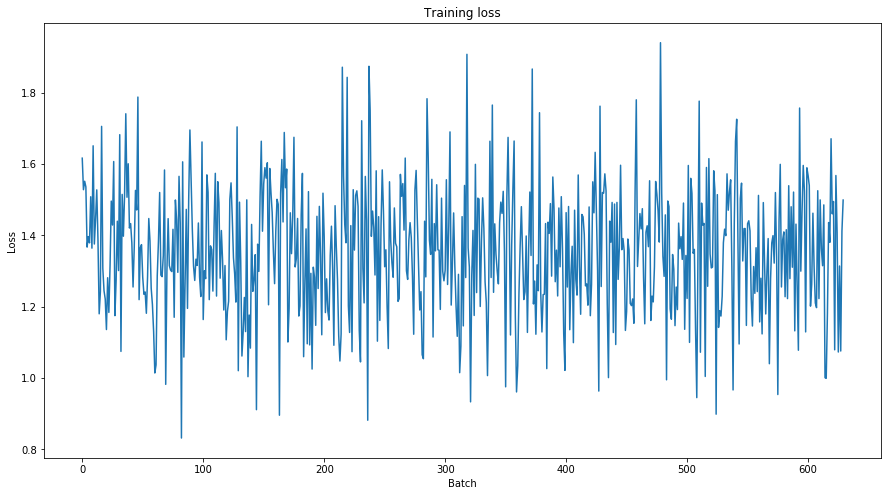

In [0]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()